# context

Project is attempting to reproduce and reanalyse null tests performed in stage III shear catalogs. We are attempting to reproduce a test in HSC found in Hamana et. al 2019 figures 19,20. <br> Our results from txpipe are such that we are obtaining a significantly larger result than what was published (in fig 20). <br> We are not sure where the issue lies or where our choices may deviate from the procedure employed in that paper.

# reproducing the issue here:

The catalog for the psf stars was retrieved from: https://cmu.app.box.com/s/gdduapkhibt8kx86etvulglyr1xl422t and the shape catalog was retreived as described here: https://hsc-release.mtk.nao.ac.jp/doc/index.php/s16a-shape-catalog-pdr2/<br> this data was compiled into 1 file.

We write a function to load each catalog here:

In [12]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

In [43]:
# tweaks were made here to match definitions to hamana..
# primarily de = emod-epsf rather than epsf-emod definition in des and TXPipe

In [13]:
def load_stars(stype):
    with h5py.File("./star_catalog_hscy1_allfields.h5","r") as f:
        g      = f["stars"]
        ra     = g["ra"][:][g[f"calib_psf_{stype}"][:] == 1.0]
        dec    = g["dec"][:][g[f"calib_psf_{stype}"][:] == 1.0]
        e1psf  = g["measured_e1"][:][g[f"calib_psf_{stype}"][:] == 1.0]
        e2psf  = g["measured_e2"][:][g[f"calib_psf_{stype}"][:] == 1.0]
        e1mod  = g["model_e1"][:][g[f"calib_psf_{stype}"][:] == 1.0]
        e2mod  = g["model_e2"][:][g[f"calib_psf_{stype}"][:] == 1.0]
        T_frac =(g["measured_T"][:][g[f"calib_psf_{stype}"][:] == 1.0] - g["model_T"][:][g[f"calib_psf_{stype}"][:] == 1.0]) / g["model_T"][:][g[f"calib_psf_{stype}"][:] == 1.0]
        #de1    = e1psf - e1mod
        #de2    = e2psf - e2mod
        de1    = e1mod - e1psf
        de2    = e2mod - e2psf
        e_psf  = np.array((e1psf, e2psf))
        e_mod  = np.array((e1mod,e2mod))
        de_psf = np.array((de1, de2))
        del e1mod, e2mod, e1psf, e2psf, de1,de2
    f.close()

    return ra, dec, e_psf, e_mod, de_psf, T_frac

In [24]:
ra, dec, e_psf, e_mod, de_psf, T_f = load_stars(stype='reserved')


In [85]:
def compute_rowe(i, ra, dec, q1, q2):
    # select a subset of the stars
    n = len(ra)
    print(f"Computing Rowe statistic rho_{i} from {n} objects")
    import treecorr

    corr = treecorr.GGCorrelation(min_sep       = 0.9,
                                  max_sep       = 110,
                                  nbins         = 21,
                                  bin_slop      = 0.01,
                                  sep_units     = "arcmin")
    cat1 = treecorr.Catalog(
        ra=ra, dec=dec, g1=q1[0], g2=q1[1], ra_units="deg", dec_units="deg", npatch=150)

    cat2 = treecorr.Catalog(
        ra=ra, dec=dec, g1=q2[0], g2=q2[1], ra_units="deg", dec_units="deg", patch_centers=cat1.patch_centers)

    corr.process(cat1, cat2)
    return corr.meanr, corr.xip, corr.varxip**0.5

In [86]:
rowe_stats = {}
rowe_stats[0] = compute_rowe(0, ra, dec, e_mod, e_mod)
rowe_stats[1] = compute_rowe(1, ra, dec, de_psf, de_psf)
rowe_stats[2] = compute_rowe(2, ra, dec, e_mod, de_psf)

Computing Rowe statistic rho_0 from 112228 objects
Computing Rowe statistic rho_1 from 112228 objects
Computing Rowe statistic rho_2 from 112228 objects


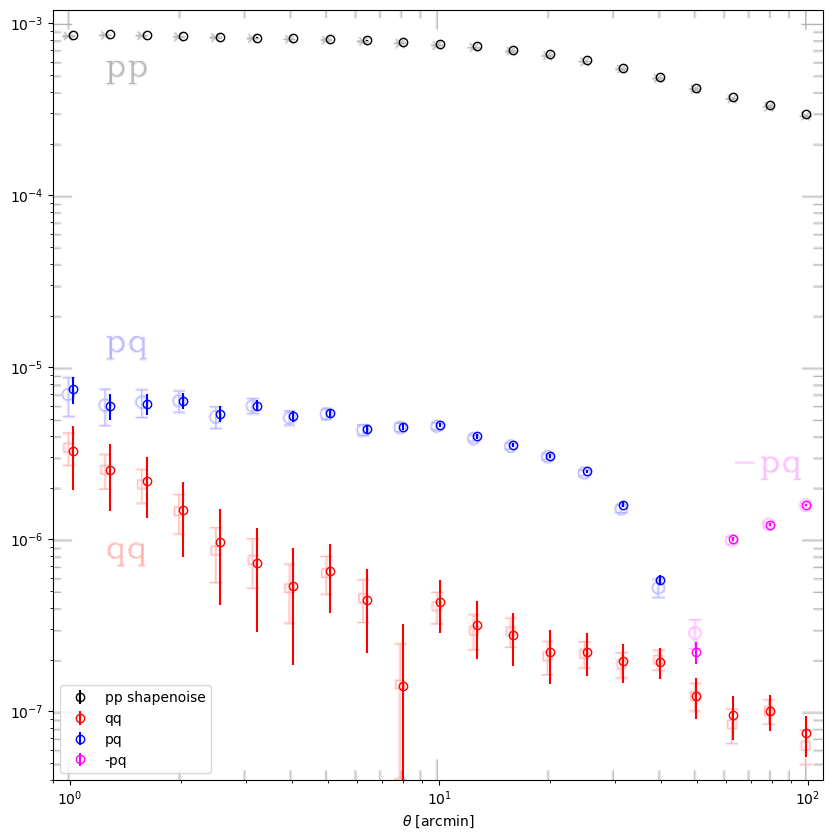

In [87]:
#set first axes
import matplotlib.ticker as ticker

fig = plt.figure(figsize=(10,10))
img = plt.imread("Hamana2019/rowe_012.png")
ax = fig.add_subplot(1,1,1)
ax.imshow(img,  aspect='equal',alpha=0.3)
plt.axis('off')

#create second axes
newax = fig.add_axes(ax.get_position(), frameon=True)
newax.patch.set_alpha(0.0)
newax.set_ylim([4e-8,1.2e-3])
newax.set_xlim([0.9,110])
newax.set_xlabel(r'$\theta$ [arcmin]')
newax.set_xscale('log')
newax.set_yscale('log')

#Change formatting of xticks
#newax.xaxis.set_minor_formatter(ticker.FormatStrFormatter('%.1f'))

plt.errorbar(rowe_stats[0][0],rowe_stats[0][1],rowe_stats[0][2],linestyle='None',marker='o',mfc='None',color='black',label='pp shapenoise')
plt.errorbar(rowe_stats[1][0],rowe_stats[1][1],rowe_stats[2][2],linestyle='None',marker='o',mfc='None',color='red',label='qq')
plt.errorbar(rowe_stats[2][0][rowe_stats[2][1]>0],rowe_stats[2][1][rowe_stats[2][1]>0],rowe_stats[2][2][rowe_stats[2][1]>0],linestyle='None',marker='o',mfc='None',color='blue',label='pq')
plt.errorbar(rowe_stats[2][0][rowe_stats[2][1]<0],-1*rowe_stats[2][1][rowe_stats[2][1]<0],rowe_stats[2][2][rowe_stats[2][1]<0],linestyle='None',marker='o',mfc='None',color='fuchsia',label='-pq')

plt.legend()
plt.show()

In [ ]:
# tau calc

In [25]:
def compute_all_tau(gra, gdec, g, gw, sra, sdec, e_mod, de_psf):
    '''
    Compute tau0, tau2
    Both need to be computed at once due to covariance.
    gra    : RA of galaxies
    gdec   : DEC of galaxies
    g      : shear for observed galaxies np.array((e1, e2))
    gw     : weights

    sra    : RA of stars
    sdec   : DEC of stars

    e_mod  : model ellipticities of PSF               -- np.array((e1mod, e2mod))
    de_psf : e_psf-e_mod                              -- np.array((e1psf, e2psf))
    '''

    import treecorr
    print("starting tau calculation...")
    p = e_mod
    q = de_psf

    sra, sdec = np.array((sra, sdec)) # Get ra/dec for specific stars
    p = np.array(( [p[0], p[1]]))     # Get p for specific stars
    q = np.array(( [q[0], q[1]]))     # Get q for specific stars

    
    # Load all catalogs
    catg = treecorr.Catalog(ra=gra, dec=gdec, g1=g[0], g2=g[1], w=gw, ra_units="deg", dec_units="deg",npatch=150) # galaxy shear
    catp = treecorr.Catalog(ra=sra, dec=sdec, g1=p[0], g2=p[1],w=np.ones(len(sra)), ra_units="deg", dec_units="deg",patch_centers=catg.patch_centers) # e_model
    catq = treecorr.Catalog(ra=sra, dec=sdec, g1=q[0], g2=q[1],w=np.ones(len(sra)), ra_units="deg", dec_units="deg",patch_centers=catg.patch_centers) # (e_* - e_model)
    del p, q

    # Compute all corrleations
    corr0 = treecorr.GGCorrelation(min_sep       = 2,
                                  max_sep       = 150,
                                  nbins         = 16,
                                  bin_slop      = 0.00,
                                   sep_units     = "arcmin")
    corr0.process(catg, catp)
    corr2 = treecorr.GGCorrelation(min_sep       = 2,
                                  max_sep       = 150,
                                  nbins         = 16,
                                  bin_slop      = 0.00,
                                   sep_units     = "arcmin")
    corr2.process(catg, catq)

    del catg, catp, catq,  

    return corr0.meanr, corr0.xip, corr0.xim, corr2.xip, corr2.xim, corr0.varxip**0.5, corr0.varxim**0.5,corr2.varxip**0.5,corr2.varxim**0.5

Plotted in comparison to Hamana et. al 2019 figure 19.

In [37]:
allgra = np.array([])
allgdec= np.array([])
allg1  = np.array([])
allg2  = np.array([])
allgw  = np.array([])

for i in range(0,4):
    print(i)

    d = '/global/cfs/cdirs/lsst/groups/WL/users/yomori/scratch/HSC/hsc2txpipe/'
    x = np.load(d+'binned_shear_catalog_allfields_zbin%d.npz'%(i+1))
    allgra  = np.concatenate([allgra, x['ra'] ])
    allgdec = np.concatenate([allgdec,x['dec']])
    allg1   = np.concatenate([allg1  ,x['g1'] ])
    allg2   = np.concatenate([allg2  ,x['g2']])
    allgw   = np.concatenate([allgw  ,x['gw'] ])

0
1
2
3


In [38]:
tht_y, c0p_y, c0m_y, c2p_y, c2m_y, c0vsnp_y, c0vsnm_y, c2vsnp_y, c2vsnm_y = compute_all_tau(allgra, allgdec, [allg1,allg2], allgw, ra, dec, e_mod, de_psf)



starting tau calculation...


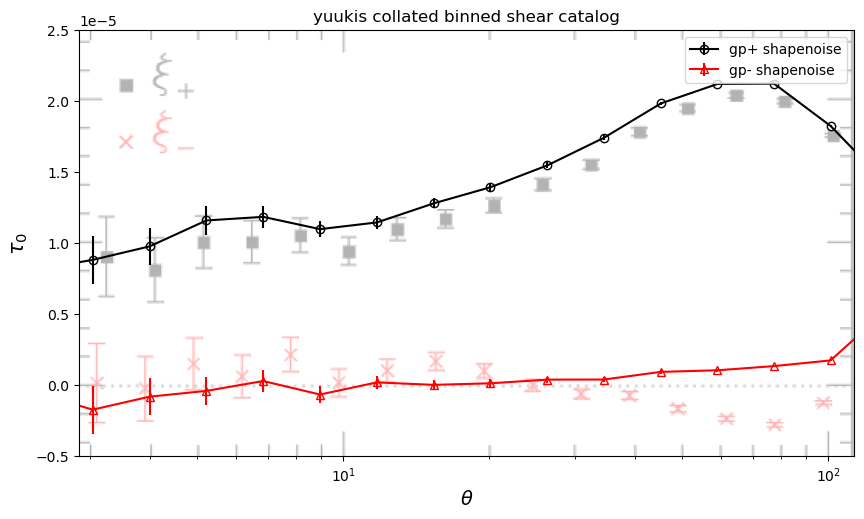

In [54]:
# plot

#set first axes
import matplotlib.ticker as ticker

fig = plt.figure(figsize=(10,10))
img = plt.imread("Hamana2019/Xi_gp.png")

ax = fig.add_subplot(1,1,1)
ax.imshow(img,  aspect='equal',alpha=0.3)
plt.axis('off')

#create second axes
newax = fig.add_axes(ax.get_position(), frameon=True)
newax.patch.set_alpha(0.0)
newax.set_xlim((2.85,113))

newax.set_ylim((-0.5e-5,2.5e-5))
newax.set_xlabel(r'$\theta\ [{\rm arcmin}]$',size=14)
newax.set_ylabel(r'$\tau_{0+}$',size=15)
newax.set_xscale('log')

#Change formatting of xticks
newax.xaxis.set_minor_formatter(ticker.FormatStrFormatter('%.1f'))
nbins=16
plt.errorbar(tht_y,c0p_y,c0vsnp_y,marker='o',mfc='None',color='black',label='gp+ shapenoise')
plt.errorbar(tht_y,c0m_y,c0vsnm_y,marker='^',mfc='None',color='red',label='gp- shapenoise')
plt.title('yuukis collated binned shear catalog')
plt.xscale('log')
plt.ylabel(r'$\tau_0$')
plt.xlabel(r'$\theta$')
plt.legend()
plt.show()

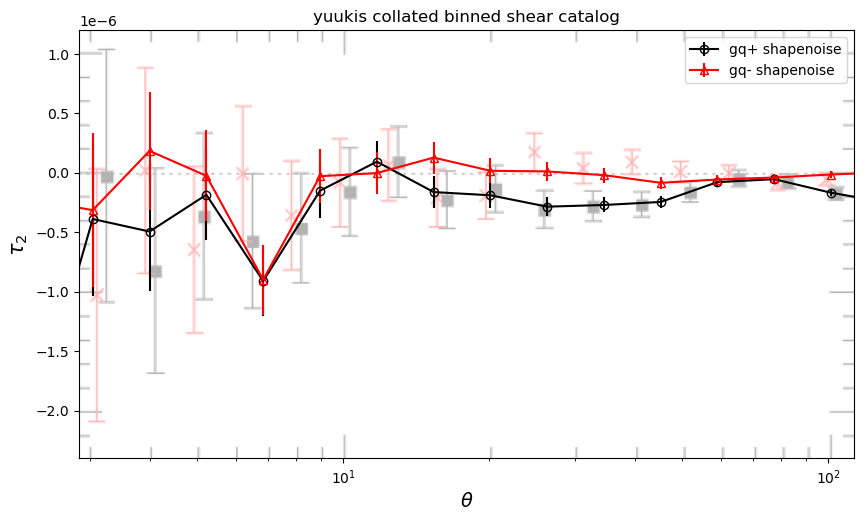

In [55]:
#set first axes
import matplotlib.ticker as ticker

fig = plt.figure(figsize=(10,10))
img = plt.imread("Hamana2019/Xi_gq.png")

ax = fig.add_subplot(1,1,1)
ax.imshow(img,  aspect='equal',alpha=0.3)
plt.axis('off')

#create second axes
newax = fig.add_axes(ax.get_position(), frameon=True)
newax.patch.set_alpha(0.0)
newax.set_xlim((2.85,113))

newax.set_ylim((-2.4e-6,1.2e-6))
newax.set_xlabel(r'$\theta\ [{\rm arcmin}]$',size=14)
newax.set_ylabel(r'$\tau_{0+}$',size=15)
newax.set_xscale('log')
#Change formatting of xticks
newax.xaxis.set_minor_formatter(ticker.FormatStrFormatter('%.1f'))
nbins=16
plt.errorbar(tht_y,c2p_y,c2vsnp_y,marker='o',mfc='None',color='black',label='gq+ shapenoise')
plt.errorbar(tht_y,c2m_y,c2vsnm_y,marker='^',mfc='None',color='red',label='gq- shapenoise')
plt.title('yuukis collated binned shear catalog')
plt.xscale('log')
plt.ylabel(r'$\tau_2$')
plt.xlabel(r'$\theta$')
plt.legend()
plt.show()